## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [1]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.

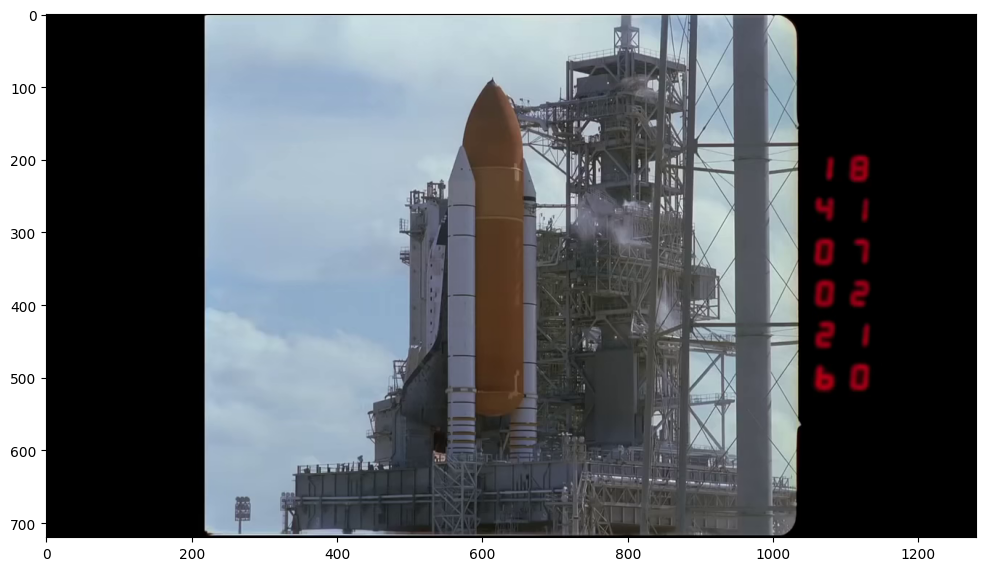

In [2]:
source = cv2.VideoCapture('dane/shuttle.mp4')
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

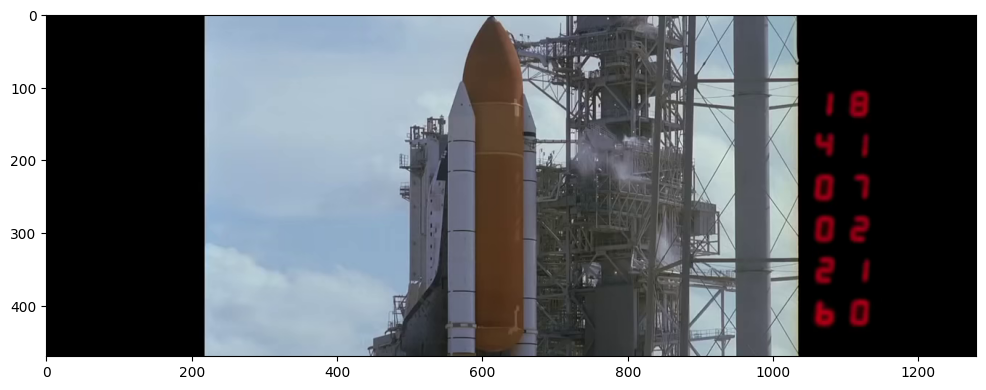

In [3]:
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.subplots(1, 1, figsize=(12,12))[1].imshow(img[90:560, :, :]);

In [4]:
pixel_to_meters = 46.9 / (560-90)

In [5]:
def test_params(frame, args, param, values):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    plt.subplots(3, 2, figsize=(20,16))
    for i, value in enumerate(values):
        curr_args = args.copy()
        curr_args[param] = value
        corners = cv2.goodFeaturesToTrack(gray, **curr_args)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        for corner in corners:
            x, y = corner.ravel()
            cv2.circle(img, (int(x), int(y)), 5, (255, 0, 0), -1)

        plt.subplot(3, 2, i+1)
        plt.title(f'{param}={value} ({len(corners)})')
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()      

In [6]:
args = {'maxCorners': 100, 'qualityLevel': 0.01, 'minDistance': 10, 'blockSize': 7}

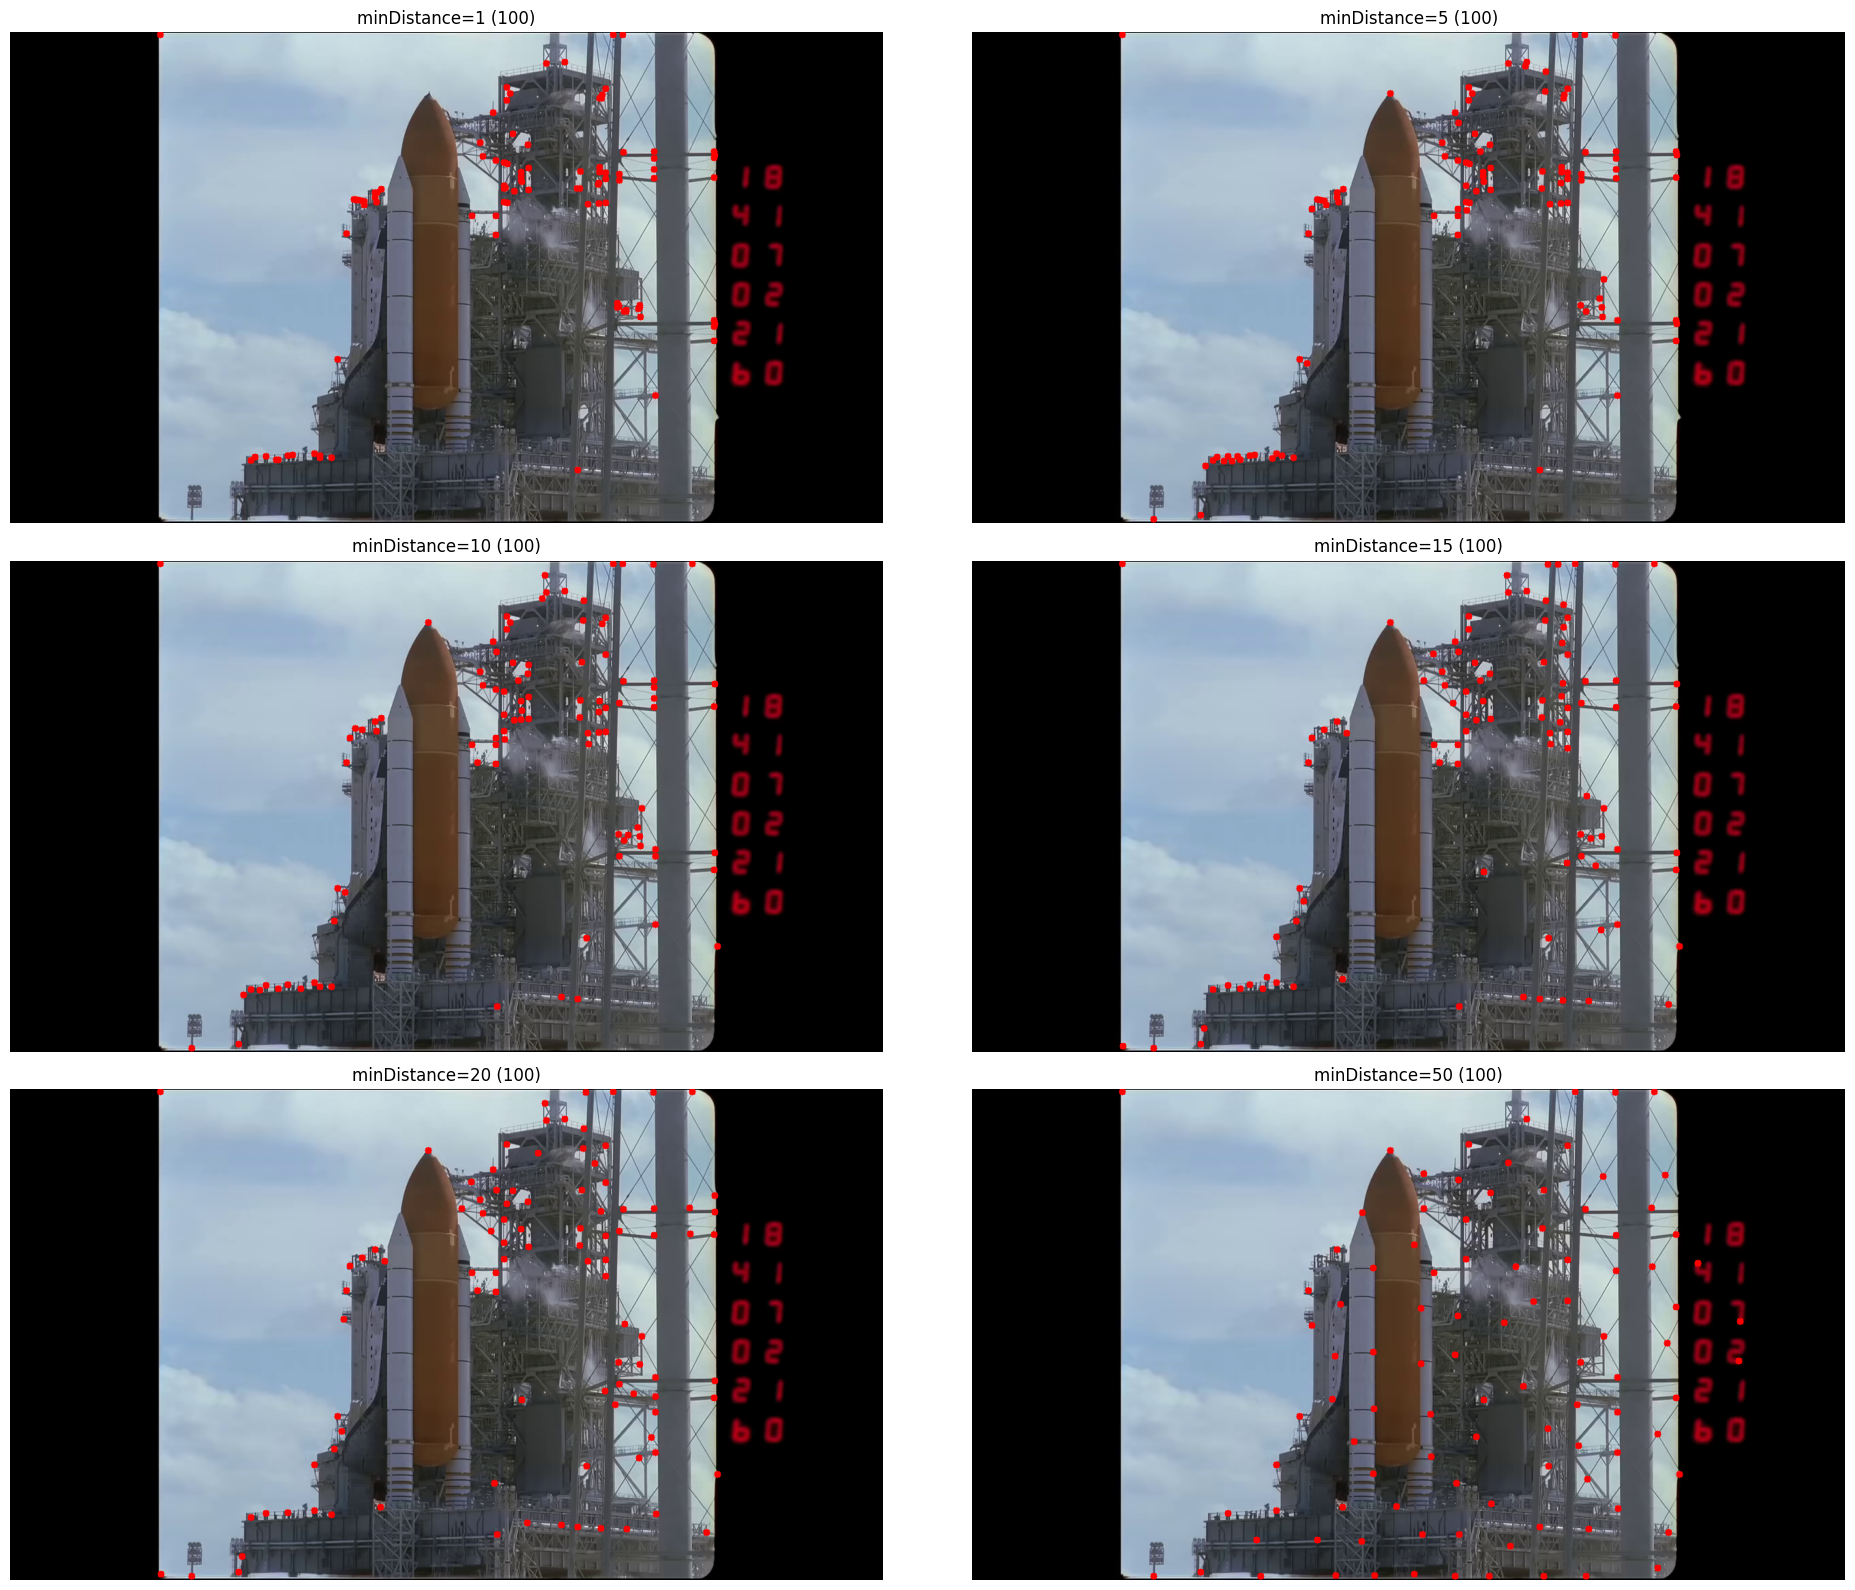

In [7]:
test_params(frame, args, 'minDistance', [1, 5, 10, 15, 20, 50])

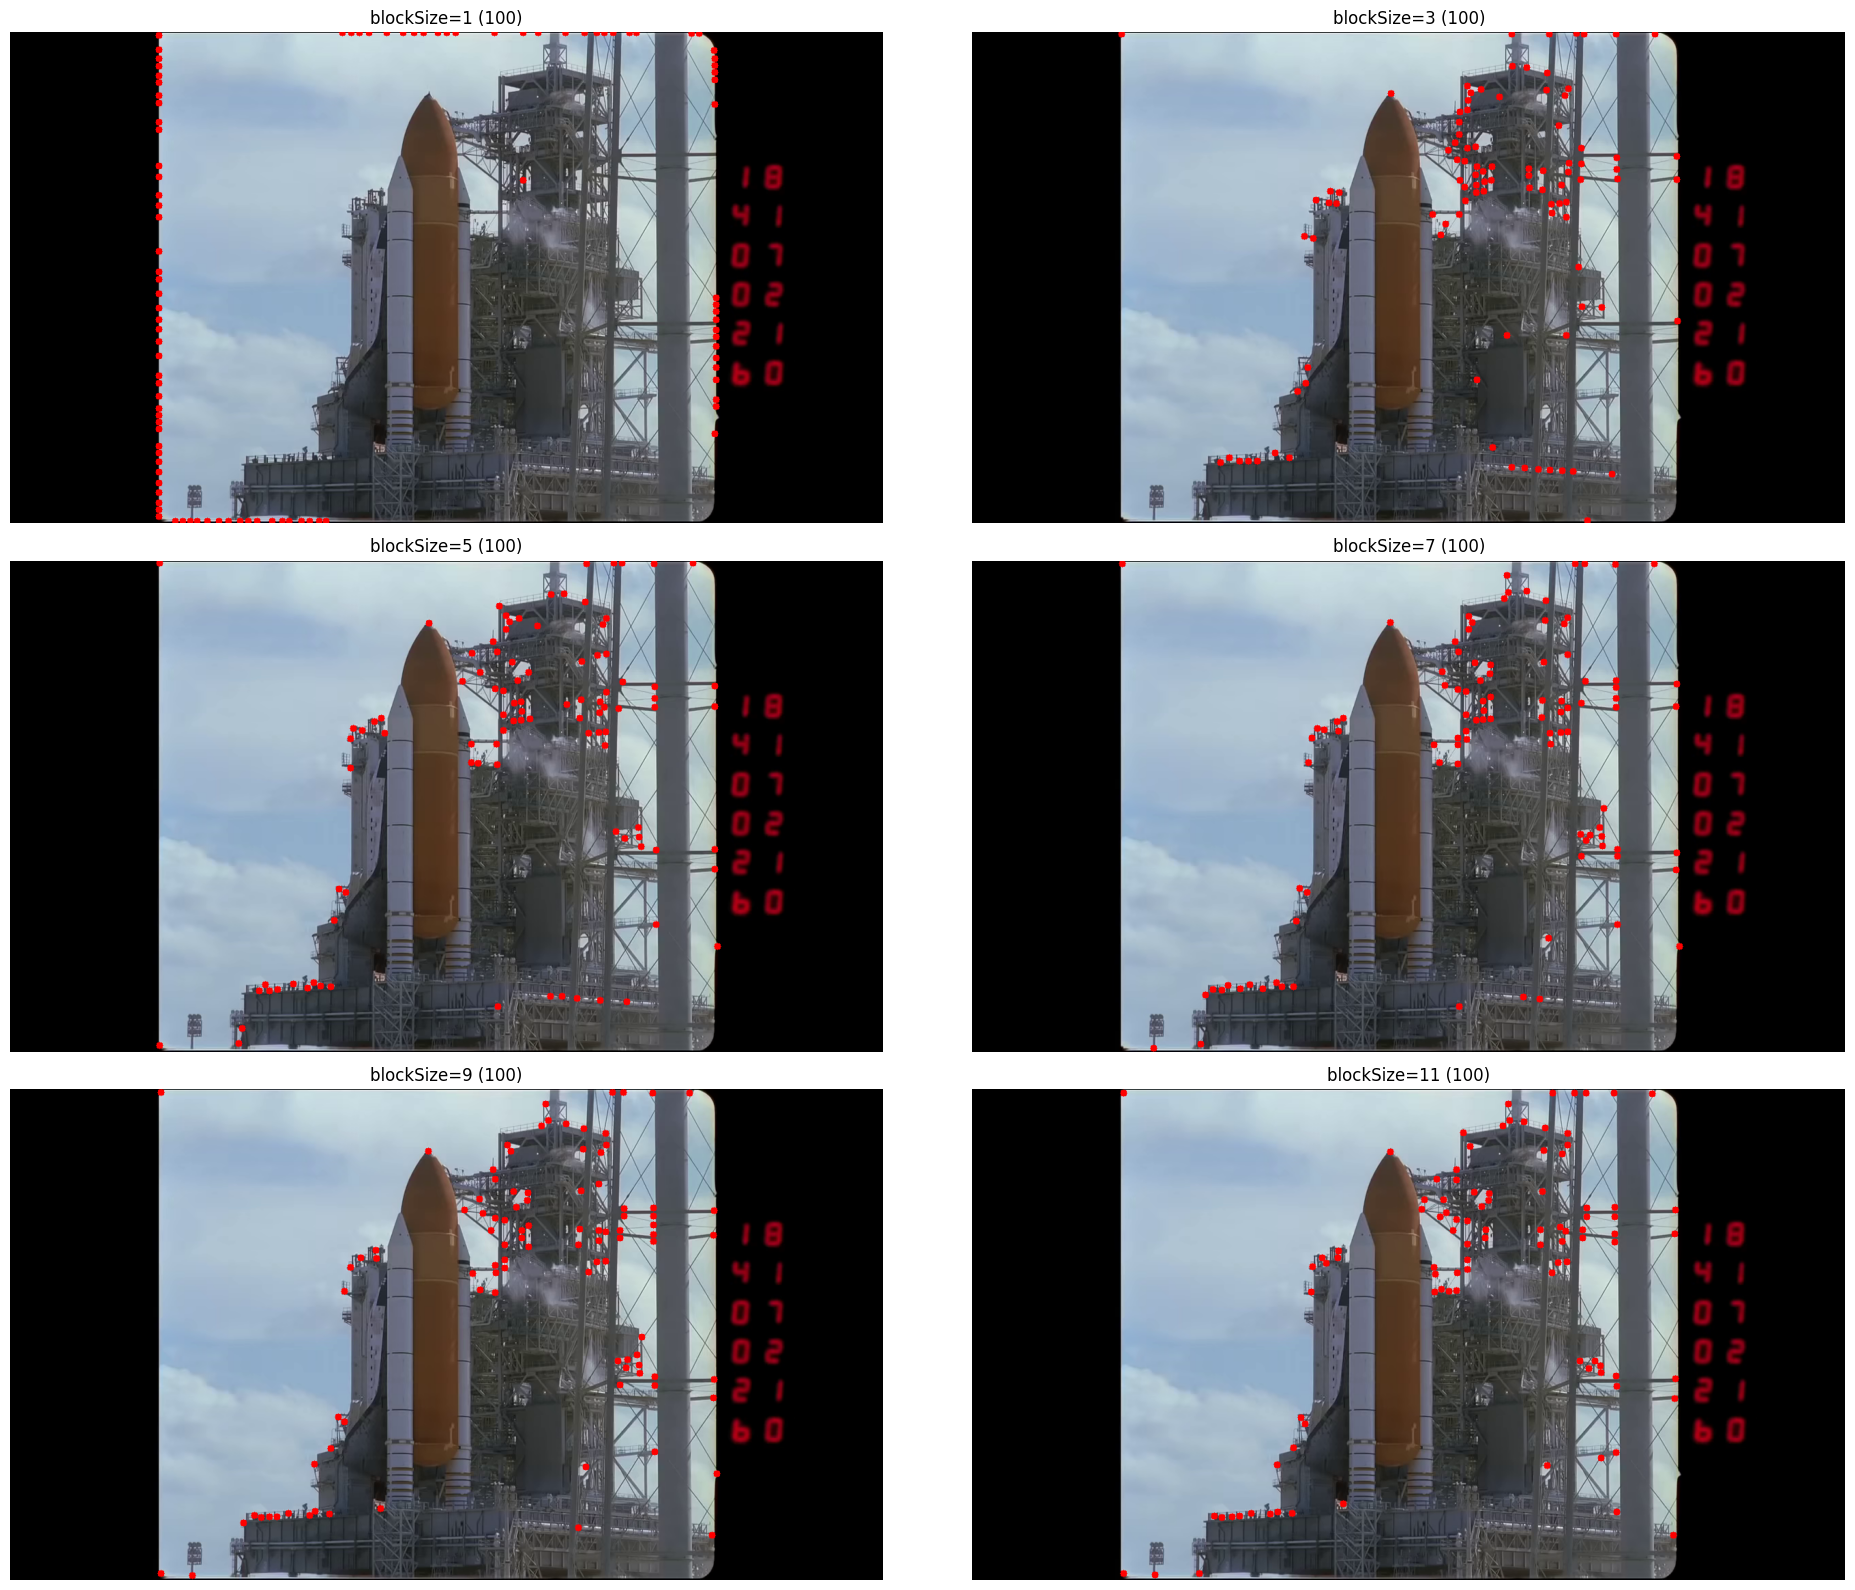

In [8]:
test_params(frame, args, 'blockSize', [1, 3, 5, 7, 9, 11])

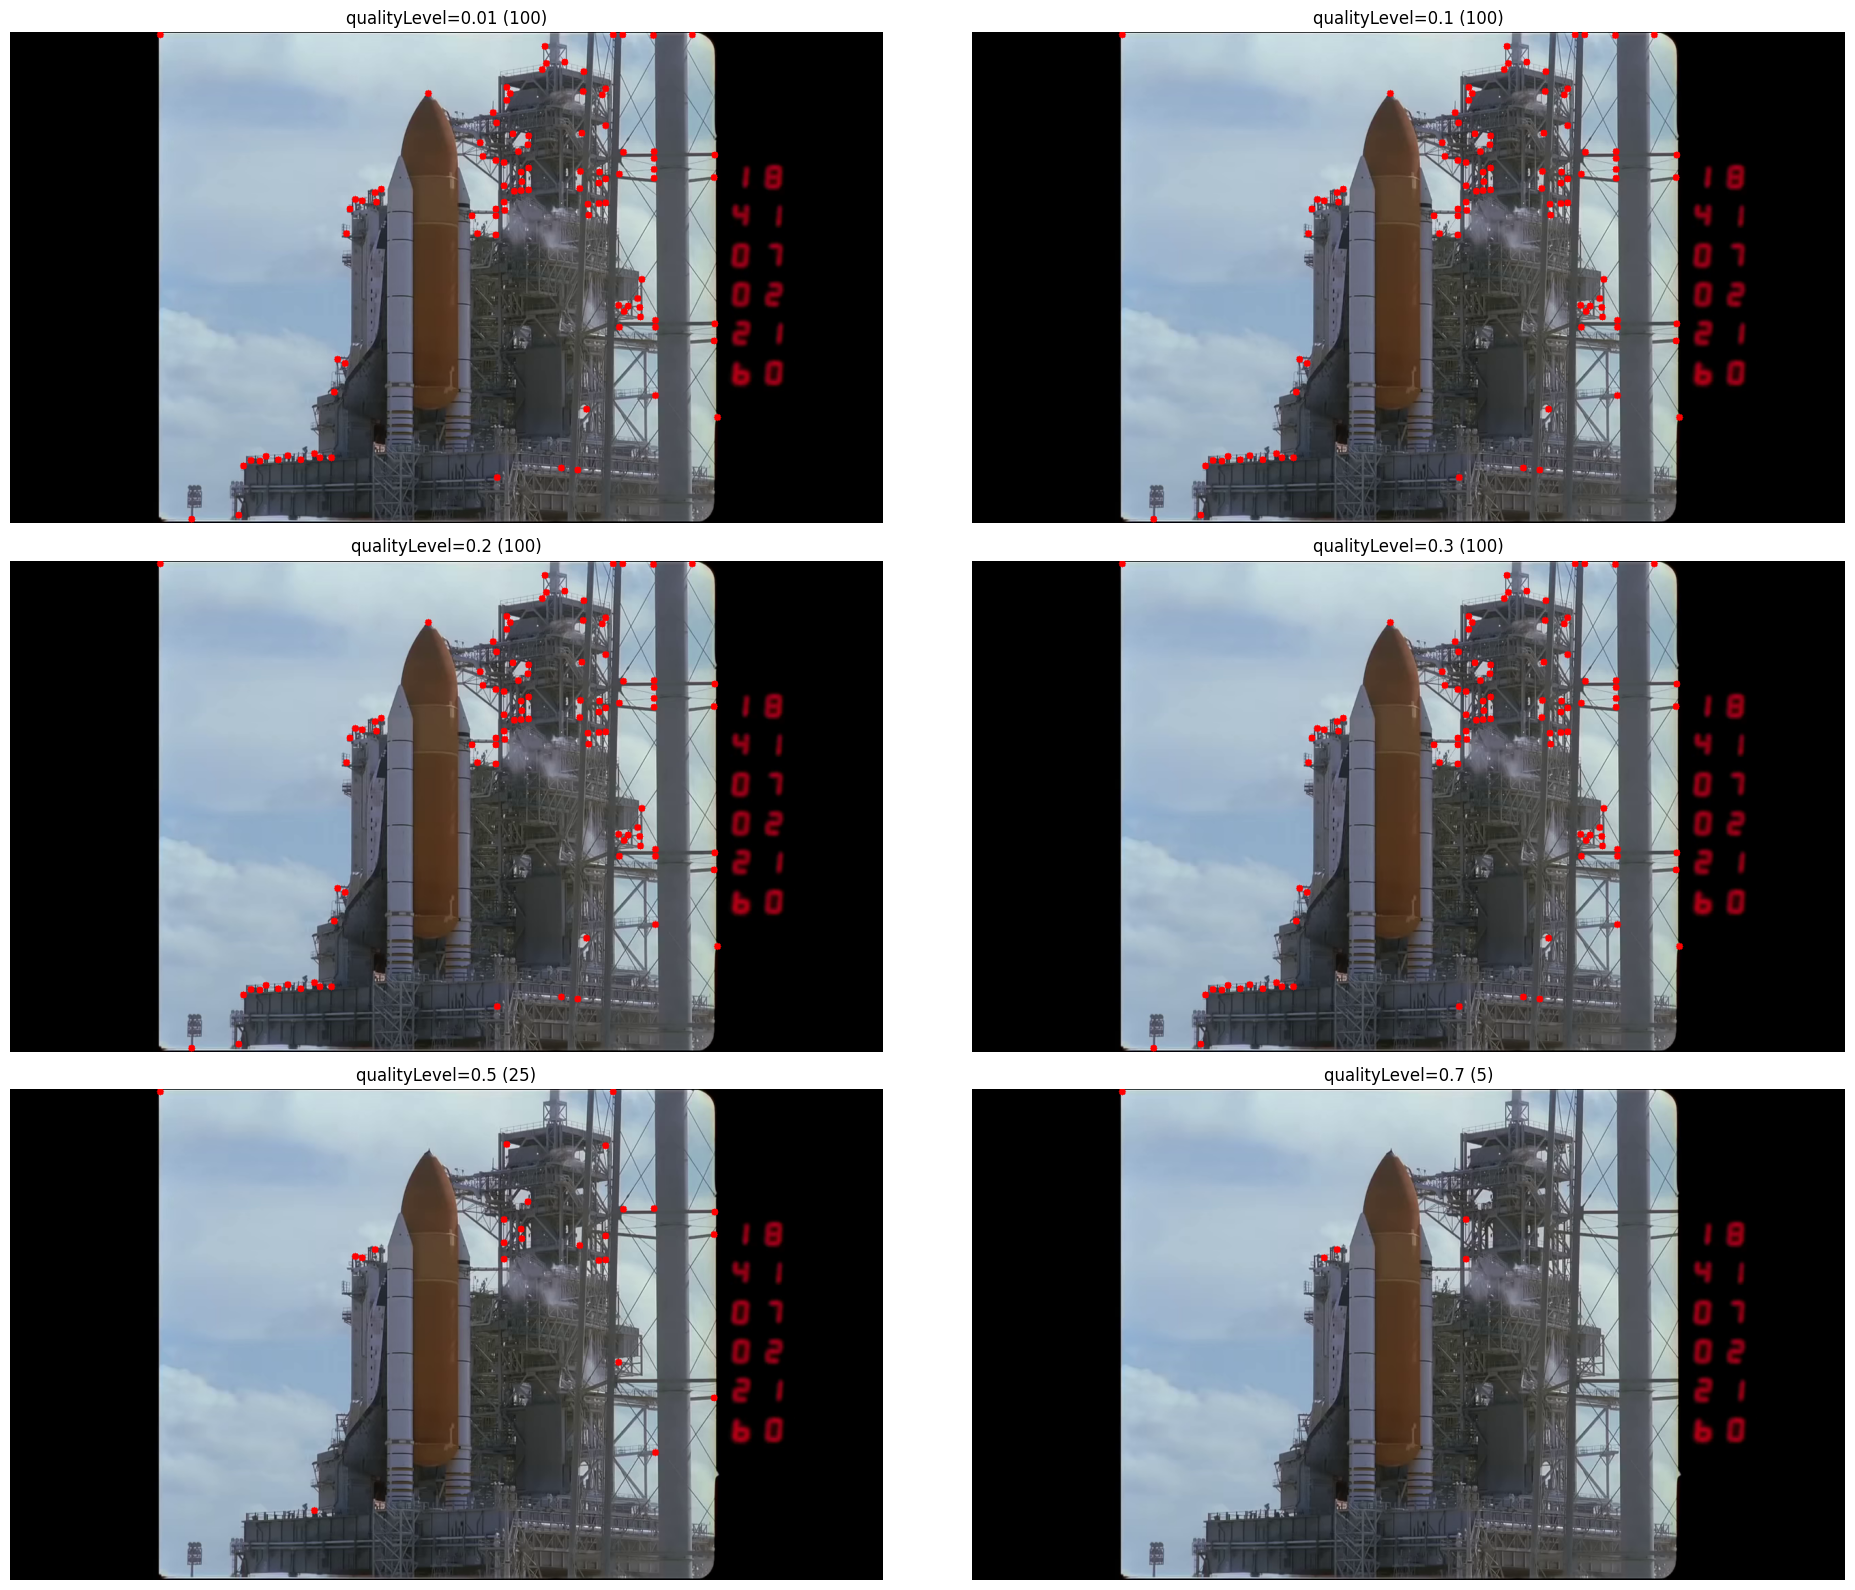

In [9]:
test_params(frame, args, 'qualityLevel', [0.01, 0.1, 0.2, 0.3, 0.5, 0.7])

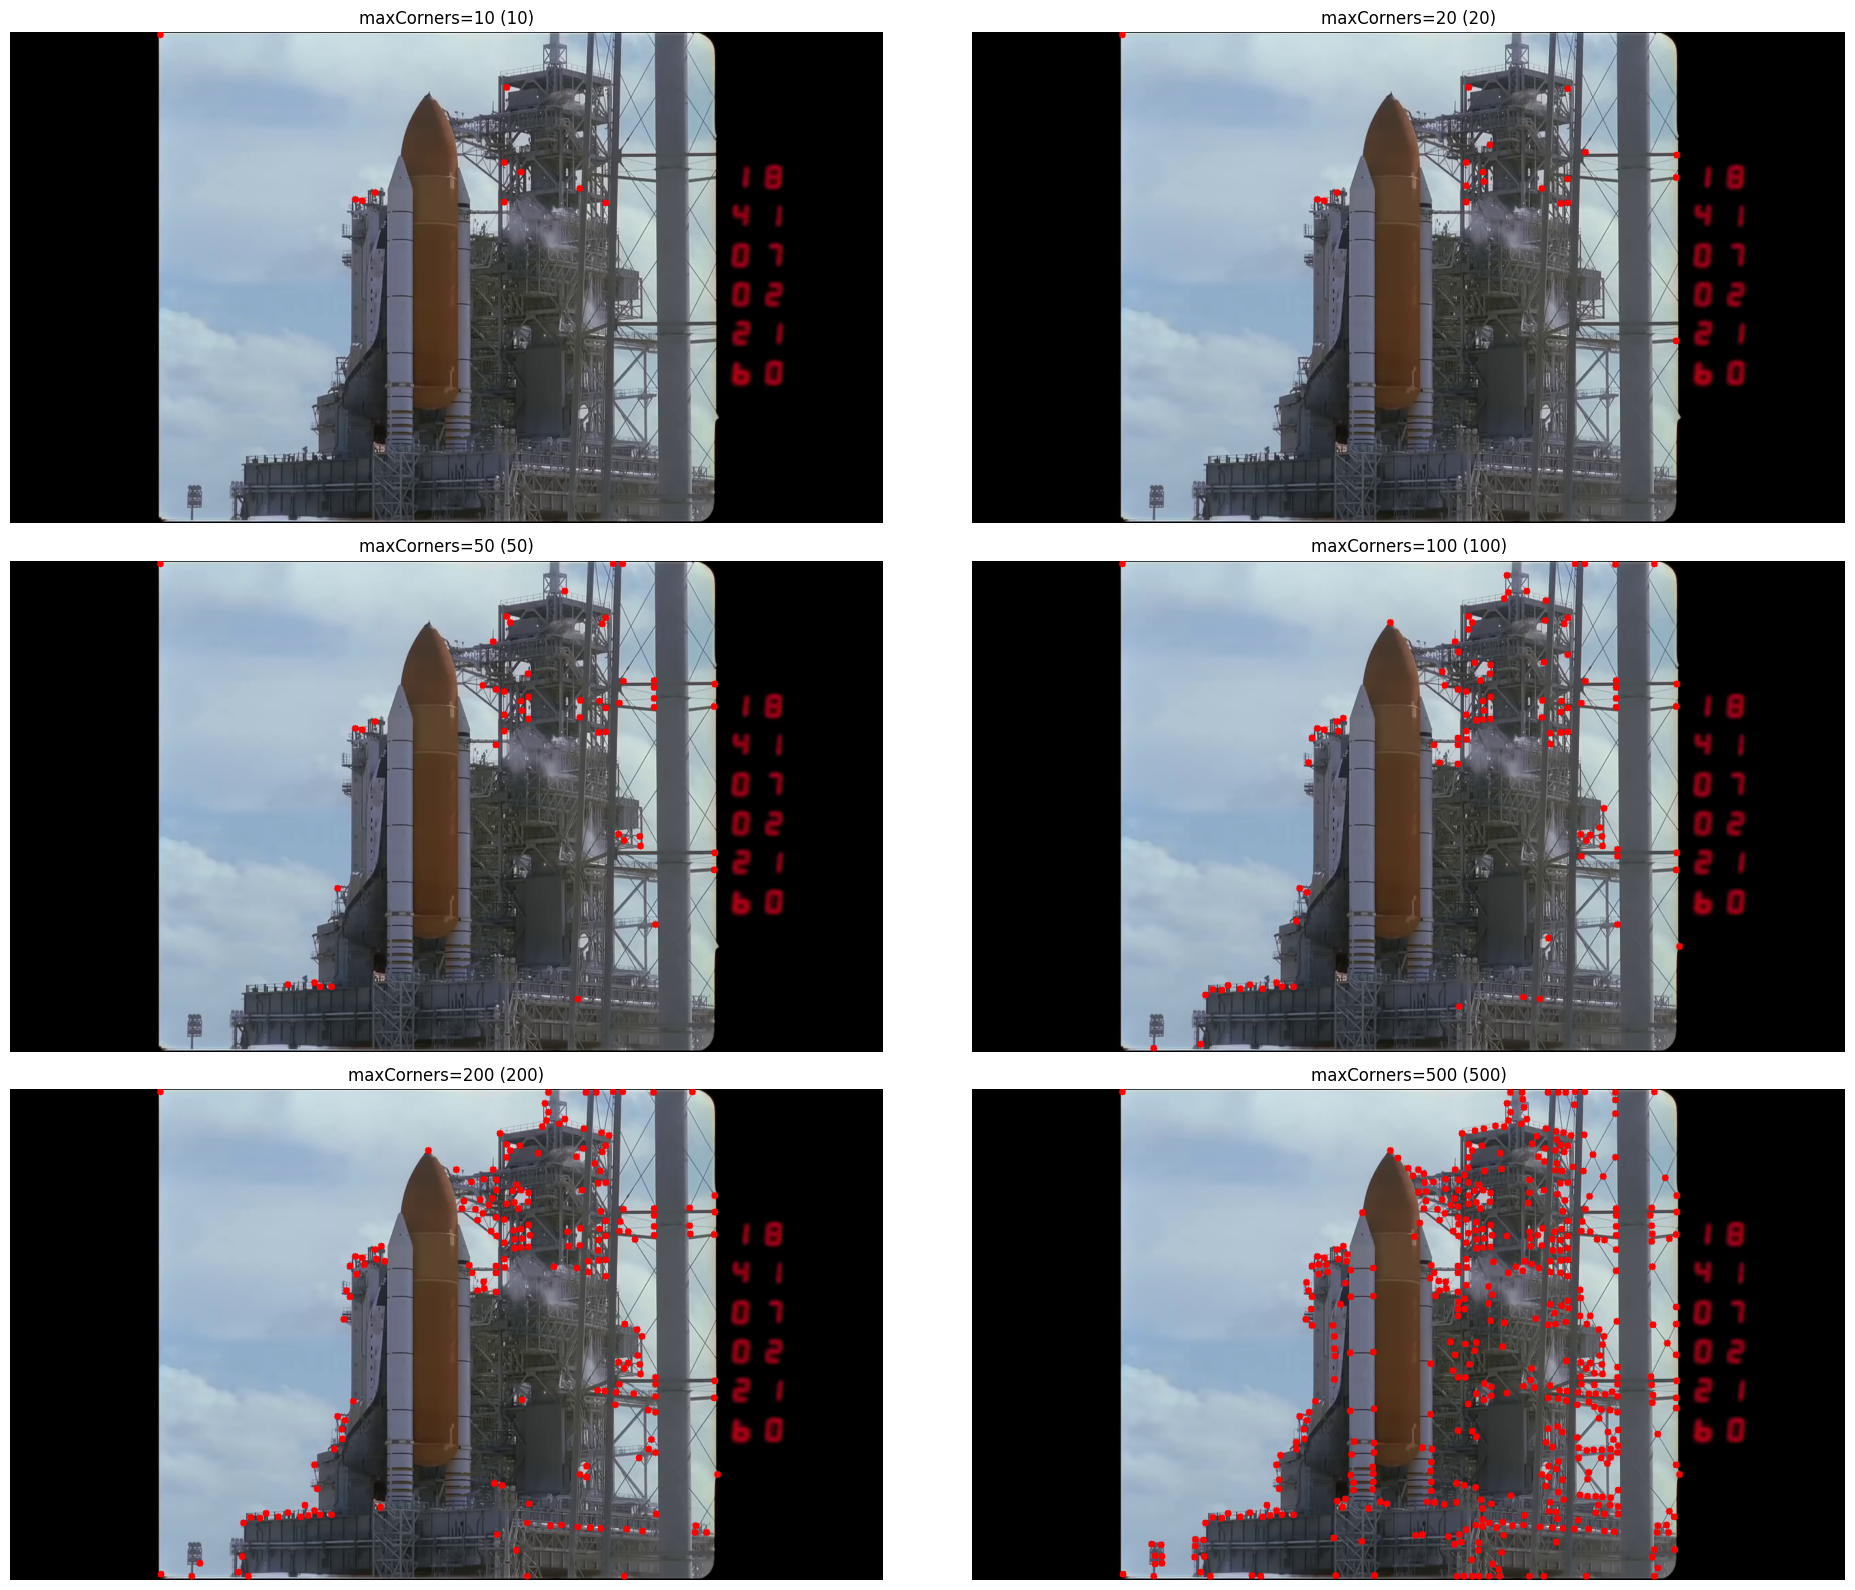

In [10]:
test_params(frame, args, 'maxCorners', [10, 20, 50, 100, 200, 500])

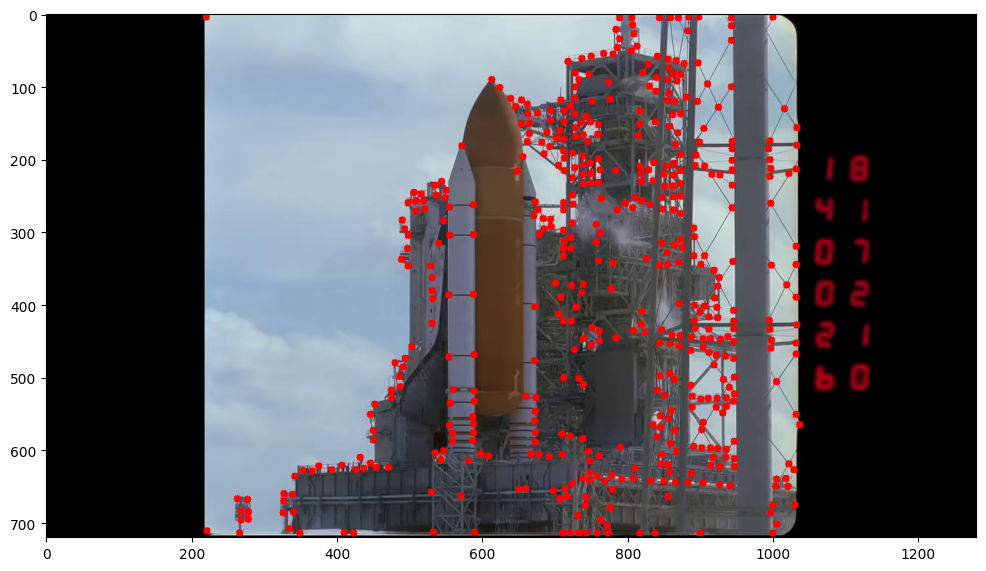

In [11]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

max_corners = 500
quality_level = 0.01
min_distance = 10
block_size = 7

corners = cv2.goodFeaturesToTrack(gray, maxCorners=max_corners, qualityLevel=quality_level, minDistance=min_distance, blockSize=block_size)

img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(img, (int(x), int(y)), 5, (255, 0, 0), -1)

plt.subplots(1, 1, figsize=(12,12))[1].imshow(img)
plt.show()

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [12]:
def baseLoop(source: cv2.VideoCapture):
    frame1 = None
    status, frame2 = source.read()
    frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    # ...
    # inicjalizacja metody
    # ...
    while status:
        frame1 = frame2
        status, frame2 = source.read()
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        # ...
        # przetwarzanie
        # ...

In [14]:
import ipywidgets as widgets
from IPython.display import display

def visualize_flow(images):
    def update_image(index):
        plt.figure(figsize=(12, 12))
        plt.imshow(images[index])
        plt.axis('off')
        plt.show()

    image_slider = widgets.IntSlider(value=1, min=1, max=len(images)-1, step=1, description='Image Index')

    output = widgets.Output()

    def on_value_change(change):
        with output:
            output.clear_output(wait=True)
            update_image(change['new'])

    image_slider.observe(on_value_change, names='value')

    display(image_slider, output)

In [131]:
def baseLoop(source: cv2.VideoCapture, filter_high_error=False, filter_by_angle=False, error_thresh=5, no_move_thresh=2, angle_thresh=0.25, memory=5):
    frame1 = None
    status, frame2 = source.read()
    trajectories = np.zeros_like(frame2)
    frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    corners = cv2.goodFeaturesToTrack(frame2, maxCorners=500, qualityLevel=0.1, minDistance=15, blockSize=7)
    velocities = []
    images = []
    j = 0
    all_directions = []
    while status:
        j+=1
        frame1 = frame2
        status, frame2 = source.read()
        if not status:
            break
        img = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        next_corners, flow_status, err = cv2.calcOpticalFlowPyrLK(frame1, frame2, corners, None)

        if filter_high_error:
            correct = []
            correct_next = []
            for i in range(len(corners)):
                if flow_status[i] == 1 and err[i][0] < error_thresh:
                    correct.append(corners[i])
                    correct_next.append(next_corners[i])
        else:
            correct = corners[flow_status == 1]
            correct_next = next_corners[flow_status == 1]

        corners = np.array(correct_next).reshape(-1, 1, 2)

        frame_velocities = []
        directions = []
        for new, old in zip(correct_next, correct):
            a, b = new.ravel()
            c, d = old.ravel()
            # if a == 0 or b == 0:
            #     continue
            diff = np.sqrt((a - c)**2 + (b - d)**2)
            if diff > no_move_thresh:
                # img = cv2.line(img, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                # img = cv2.circle(img, (int(a), int(b)), 3, (255, 0, 0), -1)
                direction = np.arctan2(b - d, a - c)
                frame_velocities.append((diff, direction, (int(a), int(b)), (int(c), int(d))))
                directions.append(direction)
            else:
                img = cv2.circle(img, (int(a), int(b)), 3, (0, 0, 255), -1)

        if directions:
            all_directions.append(directions)
        
        if frame_velocities:
            if filter_by_angle and len(all_directions) >=memory:
                dirs = [item for sublist in all_directions[-memory:] for item in sublist]
                x = np.cos(dirs)
                y = np.sin(dirs)
                X = np.mean(x)
                Y = np.mean(y)
                dominant_angle = np.arctan2(Y, X)
                filtered_velocities = []
                for v, d, end, start in frame_velocities:
                    if np.abs((d - dominant_angle + np.pi) % (2 * np.pi) - np.pi) < np.pi*angle_thresh:
                        img = cv2.line(img, end, start, (0, 255, 0), 2)
                        trajectories = cv2.line(trajectories, end, start, (0, 255, 0), 2)
                        img = cv2.circle(img, end, 3, (255, 0, 0), -1)
                        filtered_velocities.append(v)
                    else:
                        img = cv2.line(img, end, start, (0, 0, 255), 2)
                        trajectories = cv2.line(trajectories, end, start, (0, 0, 255), 2)
                        img = cv2.circle(img, end, 3, (0, 0, 255), -1)
            else:
                filtered_velocities = []
                for v, d, end, start in frame_velocities:
                    img = cv2.line(img, end, start, (0, 255, 0), 2)
                    trajectories = cv2.line(trajectories, end, start, (0, 255, 0), 2)
                    img = cv2.circle(img, end, 3, (255, 0, 0), -1)
                    filtered_velocities.append(v)
            mean_velocity = np.median([v for v in filtered_velocities]) if filtered_velocities else 0
        else:
            mean_velocity = 0

        velocities.append(mean_velocity)
        images.append(img)

    return images, velocities, trajectories

IntSlider(value=1, description='Image Index', max=358, min=1)

Output()

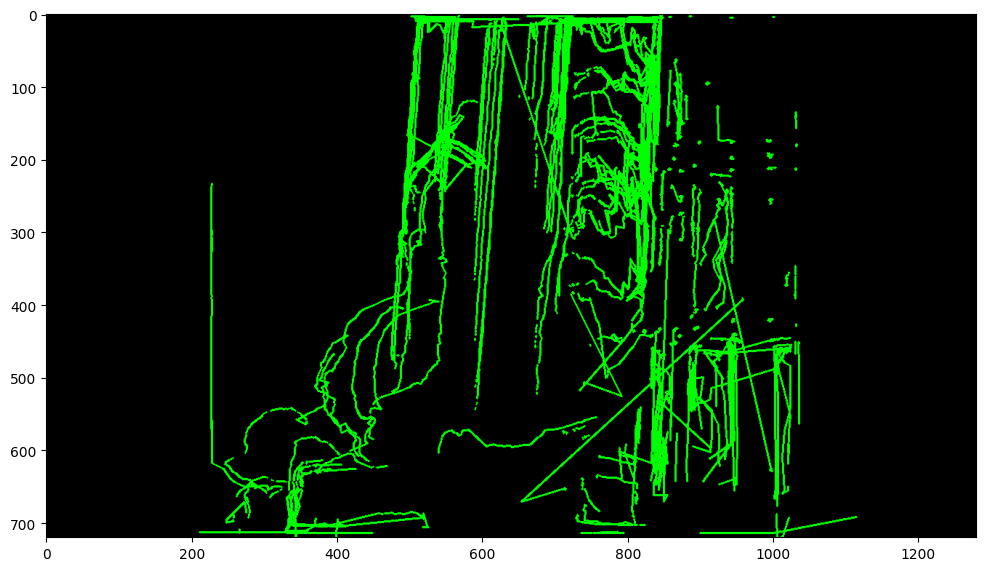

In [132]:
images1, velocities1, trajectories1 = baseLoop(cv2.VideoCapture('dane/shuttle.mp4'), False, False)
plt.subplots(1, 1, figsize=(12,12))[1].imshow(trajectories1)
visualize_flow(images1)

IntSlider(value=1, description='Image Index', max=358, min=1)

Output()

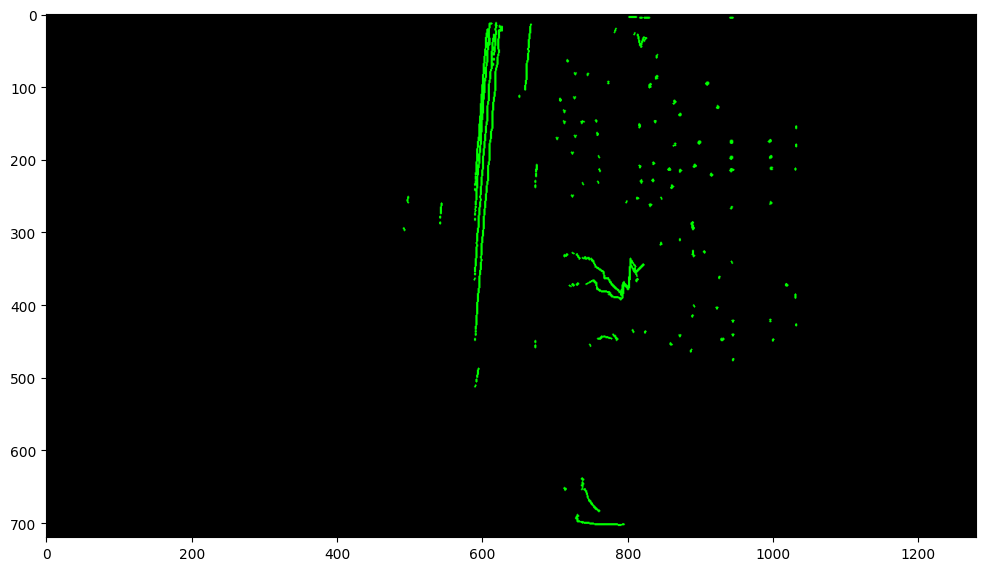

In [134]:
images2, velocities2, trajectories2 = baseLoop(cv2.VideoCapture('dane/shuttle.mp4'), True, False)
plt.subplots(1, 1, figsize=(12,12))[1].imshow(trajectories2)
visualize_flow(images2)

IntSlider(value=1, description='Image Index', max=358, min=1)

Output()

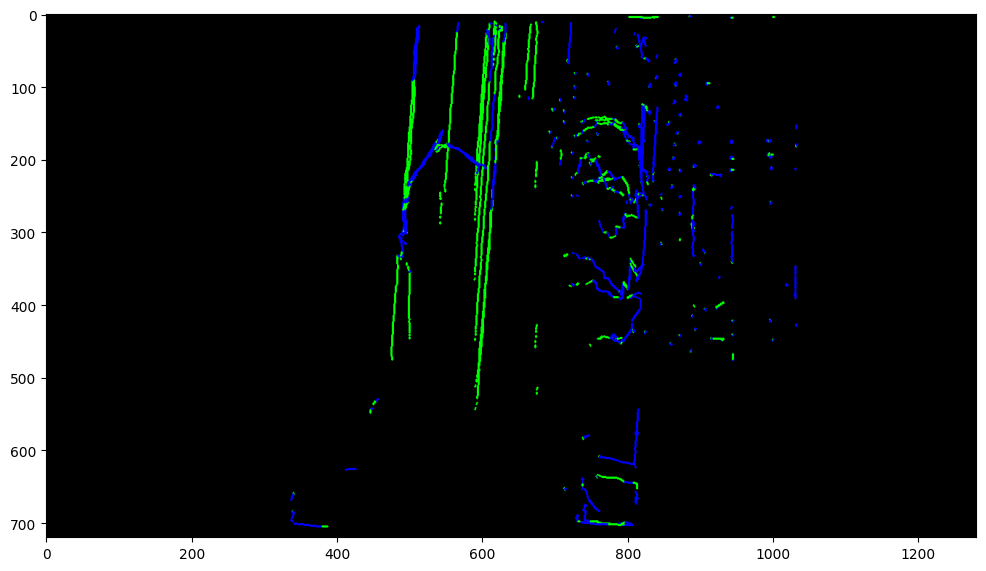

In [135]:
images3, velocities3, trajectories3 = baseLoop(cv2.VideoCapture('dane/shuttle.mp4'), True, True, error_thresh=8, angle_thresh=0.20, memory=10)
plt.subplots(1, 1, figsize=(12,12))[1].imshow(trajectories3)
visualize_flow(images3)

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.

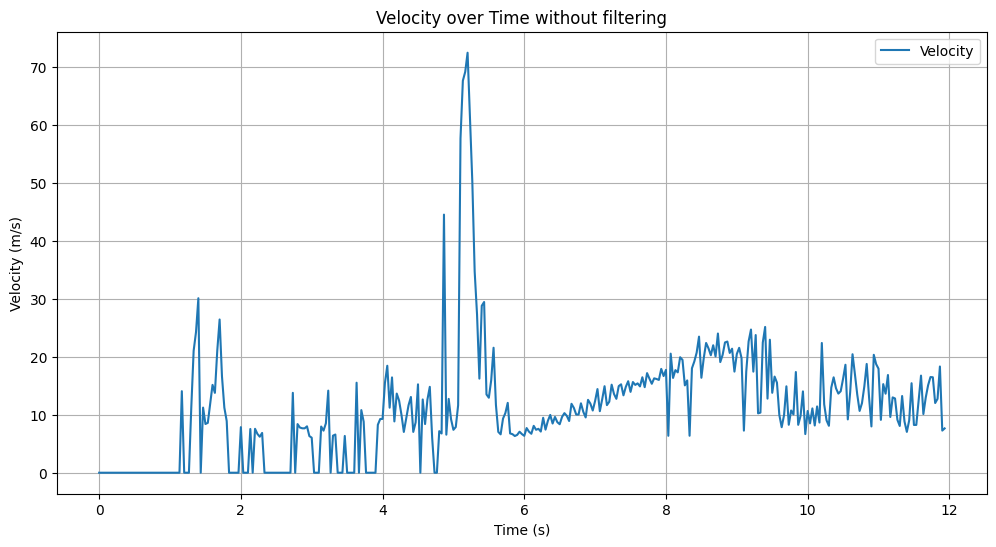

In [124]:
time = np.arange(len(velocities1)) / 30
scaled_velocities = [v * pixel_to_meters * 30 for v in velocities1]
plt.figure(figsize=(12, 6))
plt.plot(time, scaled_velocities, label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity over Time without filtering')
plt.legend()
plt.grid(True)
plt.show()

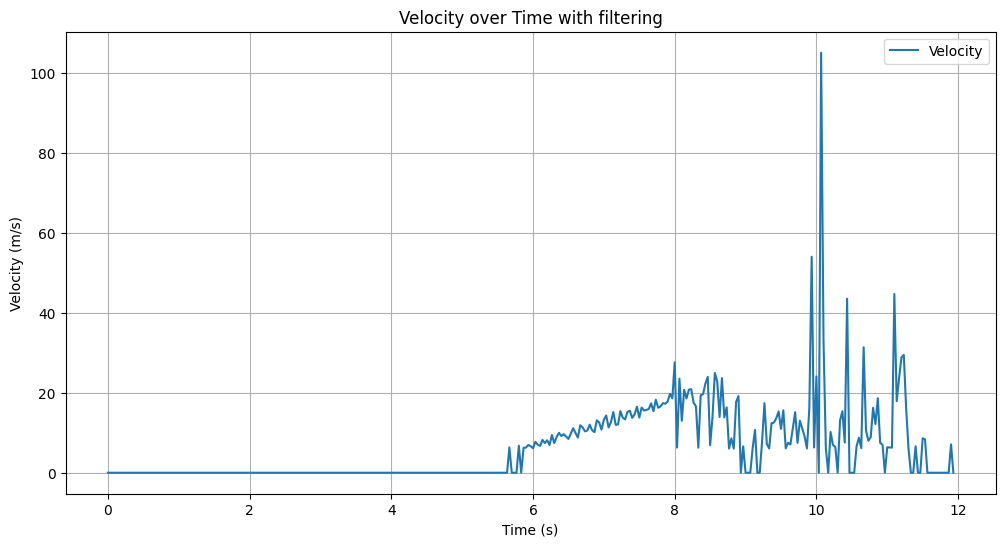

In [125]:
time = np.arange(len(velocities2)) / 30
scaled_velocities = [v * pixel_to_meters * 30 for v in velocities2]
plt.figure(figsize=(12, 6))
plt.plot(time, scaled_velocities, label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity over Time with filtering')
plt.legend()
plt.grid(True)
plt.show()

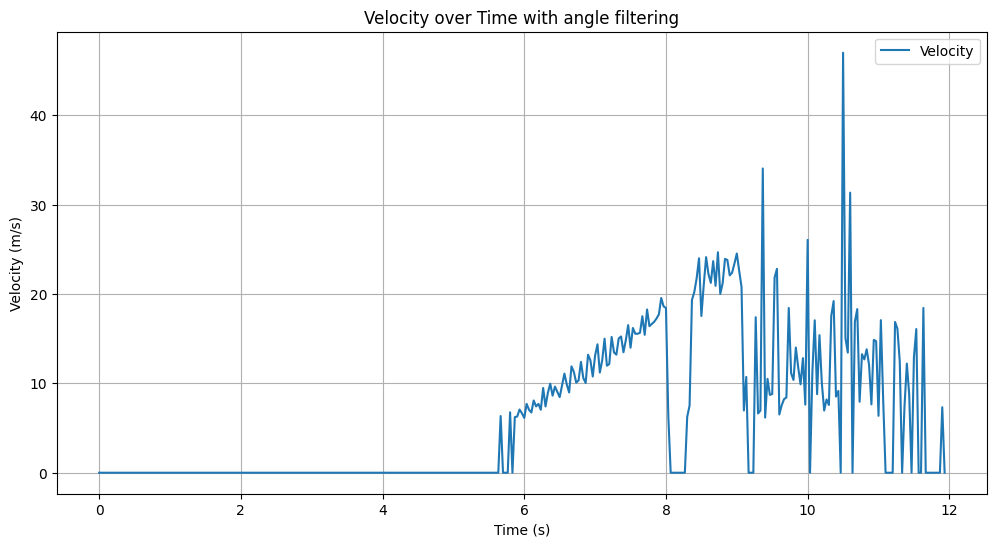

In [126]:
time = np.arange(len(velocities3)) / 30
scaled_velocities = [v * pixel_to_meters * 30 for v in velocities3]
plt.figure(figsize=(12, 6))
plt.plot(time, scaled_velocities, label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity over Time with angle filtering')
plt.legend()
plt.grid(True)
plt.show()